# TM10007 Assignment: Prediction of Tumor Grade in Brain Cancer

Group 4: Kiefer Comassi (4402359), Myrthe van Haaften (4547470), Frédérique Koopman (4470885), Stephanie Stoutjesdijk (4557808)


This notebook containt the following sections:

1. Installing and importing functions and packages

2. Loading and splitting data
3. Preprocessing before crossvalidation

   3.1 Overview of NaN's in the dataset

   3.2 Feature removal based on the number of NaN's

   3.3 Patient removal based on the number of NaN's
   
   3.4 Evaluation of data distribution and outliers

4. Function definitions

    4.1 Imputation
    
    4.2 Scaling

    4.3 Feature selection/dimensionality reduction

    4.4 Hyperparameter optimization feature selection method

    4.5 Randomized grid searches

    4.6 Performance metrics

    4.7 Learning curves

5. Evaluation of feature selection methods

6. Outer and inner crossvalidation

7. Performance of classifiers

## 1. Installing and importing functions and packages

In [4]:
# Run this to use from colab environment
 !pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
 !pip install missingpy
 !pip install flake8 pycodestyle_magic

In [5]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt

from scipy.stats import shapiro, uniform
from sklearn.model_selection import (
                                    StratifiedKFold, StratifiedShuffleSplit,
                                    RandomizedSearchCV, learning_curve)
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import (
                                    RFECV, SelectKBest, mutual_info_classif, 
                                    SelectFromModel)
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from missingpy import KNNImputer

from brats.load_data import load_data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# %load_ext pycodestyle_magic

In [0]:
#%pycodestyle_off

## 2. Loading and splitting data 

In [0]:
# Load data
data = load_data()

# Splitting data into feature values and patient labels
FEATURES = data.drop(columns=['label'])
LABELS = data['label']

GBM = FEATURES.loc[LABELS == 'GBM']
LGG = FEATURES.loc[LABELS == 'LGG']

## 3. Preprocessing before crossvalidation

3.1 Overview of the NaN's in the dataset

In [0]:
# Determining the number of NaN's

# Number of NaN's per patient for GBM and LGG patients
NO_NAN_ROW_TOTAL = FEATURES.isnull().sum(axis=1)
# Number of NaN's per feature for GBM and LGG patients
NO_NAN_COL_TOTAL = FEATURES.isnull().sum(axis=0)

# Number of NaN's per feature for GBM patients
GBM_NO_NAN_COL = GBM.isnull().sum(axis=0)
# Number of NaN's per feature for LGG patients
LGG_NO_NAN_COL = LGG.isnull().sum(axis=0)

3.2 Feature removal based on the number of NaN's. 

Threshold = the maximum number of NaN's in a column, above which a feature is discarded

In [10]:
# Define percentage of patients with no data for a certain feature, above which the feature is discarded
PERC_MISSING_GBM = 30
PERC_MISSING_LGG = 30

# Define threshold based on number of NaN's for discarding features
THRESHOLD_GBM = floor((PERC_MISSING_GBM/100) * len(GBM.index))
THRESHOLD_LGG = floor((PERC_MISSING_LGG/100) * len(LGG.index))

# Initialisation
FEATURES_REMOVED = []

# Append names of features that should be removed
for feature in GBM_NO_NAN_COL[GBM_NO_NAN_COL > THRESHOLD_GBM].index[:]:
    FEATURES_REMOVED.append(feature)

for feature in LGG_NO_NAN_COL[LGG_NO_NAN_COL > THRESHOLD_LGG].index[:]:
    FEATURES_REMOVED.append(feature)

# Remove features from dataset
DATA_FEAT_SEL = FEATURES.drop(columns=[features for features in set(FEATURES_REMOVED)])

print(f'{len(DATA_FEAT_SEL.columns)}/{len(FEATURES.columns)} features are left in dataset')

482/724 features are left in dataset


3.3 Patient removal based on the number of NaN's. Threshold = the maximum number of NaN's in a row.

In [11]:
# Define threshold of number of NaN's above which a patient is removed
PERC_MISSING_SAMPLE = 30
THRESHOLD_SAMPLE = floor((PERC_MISSING_SAMPLE/100) * len(DATA_FEAT_SEL.columns))

# Number of NaN's per patient after feature removal
NO_NAN_ROW_TRAIN = DATA_FEAT_SEL.isnull().sum(axis=1)

# Initialisation
SAMPLES_REMOVED = []
LABELS_SEL = LABELS

# Looping over the trainingset to remove patients with a number of NaN's above the threshold
print('The following sample(s) is/are removed from dataset:')
for sample in NO_NAN_ROW_TRAIN[NO_NAN_ROW_TRAIN > THRESHOLD_SAMPLE].index[:]:
    if sample:
        print(sample)
        SAMPLES_REMOVED.append(sample)
        DATA_FEAT_SEL = DATA_FEAT_SEL.drop(index=sample)
        LABELS_SEL = LABELS_SEL.drop(index=sample)

print(f'{len(DATA_FEAT_SEL)}/{len(FEATURES)} samples are left in dataset')

The following sample(s) is/are removed from dataset:
TCGA-HT-7686
166/167 samples are left in dataset


3.4 Evaluation of data distribution and outliers

In [31]:
# Evaluate data distribution
# Impute GBM and LGG patients separately
IMPUTER_GBM = KNNImputer(n_neighbors=5, weights="distance")
IMPUTER_LGG = KNNImputer(n_neighbors=5, weights="distance")

X_GBM = DATA_FEAT_SEL[LABELS_SEL == 'GBM']
X_IMP_GBM = IMPUTER_GBM.fit_transform(X_GBM)

X_LGG = DATA_FEAT_SEL[LABELS_SEL == 'LGG']
X_IMP_LGG = IMPUTER_LGG.fit_transform(X_LGG)

# Evaluate distributions of features for GBM patients
NO_NON_NORMAL_GBM = 0
FEAT_NON_NORM_GBM = list()

for index, feature in enumerate(X_IMP_GBM.T):
    t_stat, p_value = shapiro(feature)
    if p_value < 0.05:
        NO_NON_NORMAL_GBM += 1          # Number of non normally distributed features
        FEAT_NON_NORM_GBM.append(index)
print(f'In the GBM class, {NO_NON_NORMAL_GBM} features are not normally distributed.')

# Evaluate distributions of features for LGG patients
NO_NON_NORMAL_LGG = 0
FEAT_NON_NORM_LGG = list()
for index, feature in enumerate(X_IMP_LGG.T):
    t_stat, p_value = shapiro(feature)
    if p_value < 0.05:
        NO_NON_NORMAL_LGG += 1          # Number of non normally distributed features
        FEAT_NON_NORM_LGG.append(index)
print(f'In the LGG class, {NO_NON_NORMAL_LGG} features are not normally distributed.')

In the GBM class, 435 features are not normally distributed.
In the LGG class, 384 features are not normally distributed.


In [30]:
# Evaluate number of outliers per patient group (LGG and GBM), depending on the Interquartile Range (IQR)

# Evaluate per GBM patient each feature
NO_OUTLIERS_GBM = 0

# Loop over patients
for patient in X_IMP_GBM:
    feat_out = 0
    # Loop over features
    for index, feature in enumerate(patient):
        # Determine quartiles and interquartile range (IQR)
        q25, q75 = np.percentile(X_IMP_GBM[:,index], 25), np.percentile(X_IMP_GBM[:,index], 75)
        iqr = q75 - q25
        # Define cut-off for outlier evaluation and lower and upper bounds
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        # Determine whether patient has an exceptional feature value
        outlier = ((feature > upper) | (feature < lower))
        # Count number of features for which patient has exceptional feature value
        feat_out += outlier
    # Classify patient as outlier when he has exceptional values for > 70 features
    if feat_out > 70:
        NO_OUTLIERS_GBM += 1
print(f'In the GBM class, {NO_OUTLIERS_GBM} patients are considered to be outliers')

# Evaluate per LGG patient each feature
NO_OUTLIERS_LGG = 0

for patient in X_IMP_LGG:
    feat_out = 0
    for index, feature in enumerate(patient):
        q25, q75 = np.percentile(X_IMP_LGG[:,index], 25), np.percentile(X_IMP_LGG[:,index], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = ((feature>upper) | (feature<lower))
        feat_out += outlier
    if feat_out > 70:
        NO_OUTLIERS_LGG += 1
print(f'In the LGG class, {NO_OUTLIERS_LGG} patients are considered to be outliers.')
print(f"For the complete dataset, this means that {(NO_OUTLIERS_LGG + NO_OUTLIERS_GBM)/(len(DATA_FEAT_SEL)) * 100}% is an outlier")


In the GBM class, 7 patients are considered to be outliers
In the LGG class, 4 patients are considered to be outliers.
For the complete dataset, this means that 6.626506024096386% is an outlier


## 4. Function definitions

4.1 Imputation

In [0]:
def knn_impute_train_test_set(X_train, X_test):
    """
    Fit k-nearest neighbor imputer on train set and impute train and test set using this fitted imputer.
    Input:
    X_train : array-like, shape (n_samples, n_features)
                Training vector, where n_samples is the number of samples and
                n_features is the number of features.
    X_test : array-like, shape (n_samples, n_features)
                Test vector, where n_samples is the number of samples and
                n_features is the number of features.

    Output:
    X_train_imp: array-like, shape (n_samples, n_features)
                Imputed train data.

    X_test_imp: array-like, shape (n_samples, n_features)
                Imputed test data.
    """

    imputer = KNNImputer(n_neighbors=5, weights="distance")
    imputer.fit(X_train)
    X_train_imp = imputer.transform(X_train)
    X_test_imp = imputer.transform(X_test)
    return X_train_imp, X_test_imp

4.2 Scaling

In [0]:
def scale_train_test_set(X_train, X_test):
    """
    Fit MinMax scaler on train set and scale train and test set using this fitted scaler.
    Input:
    X_train : array-like, shape (n_samples, n_features)
                Training vector, where n_samples is the number of samples and
                n_features is the number of features.
    X_test : array-like, shape (n_samples, n_features)
                Test vector, where n_samples is the number of samples and
                n_features is the number of features.

    Output:
    X_train_scal: array-like, shape (n_samples, n_features)
                Scaled train data.

    X_test_scal: array-like, shape (n_samples, n_features)
                Scaled test data.
    """
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scal = scaler.transform(X_train)
    X_test_scal = scaler.transform(X_test)
    return X_train_scal, X_test_scal

4.3 Feature selection/dimensionality reduction

In [0]:
def select_features_univariate(X_train, y_train, X_test, k_value):
    """
    Univariate feature selection using the Mutual Information Criterion.
    Fit on training set and transform training and test set.
    Input:
    X_train : array-like, shape (n_samples, n_features)
                Training vector, where n_samples is the number of samples and
                n_features is the number of features.
    y_train: array-like, shape (n_samples)
                Target relative to X_train for classification.
    X_test : array-like, shape (n_samples, n_features)
                Test vector, where n_samples is the number of samples and
                n_features is the number of features.

    Output:
    X_train_sel: array-like, shape (n_samples, n_features_selected)
                Training vector, where n_samples is the number of samples and
                n_features_selected is the number of selected features.
    X_test_sel: array-like, shape (n_samples, n_features_selected)
                Test vector, where n_samples is the number of samples and
                n_features_selected is the number of selected features.
    selection_method.get_support: array-like
                Indices of the feature columns dat were selected
    """
    selection_method = SelectKBest(mutual_info_classif, k=k_value).fit(X_train, y_train)
    X_train_sel = selection_method.transform(X_train)
    X_test_sel = selection_method.transform(X_test)
    return X_train_sel, X_test_sel, selection_method.get_support(indices=True)

In [0]:
def select_features_l1(X_train, y_train, X_test, threshold_value):
    """
    L1-based feature selection. Fit on training set and transform training and test set.

    Input:
    X_train : array-like, shape (n_samples, n_features)
                Training vector, where n_samples is the number of samples and
                n_features is the number of features.
    y_train: array-like, shape (n_samples)
                Target relative to X_train for classification.
    X_test : array-like, shape (n_samples, n_features)
                Test vector, where n_samples is the number of samples and
                n_features is the number of features.
    threshold_value: string or float
                The threshold value to use for feature selection.

    Output:
    X_train_sel: array-like, shape (n_samples, n_features_selected)
                Training vector, where n_samples is the number of samples and
                n_features_selected is the number of selected features.
    X_test_sel: array-like, shape (n_samples, n_features_selected)
                Test vector, where n_samples is the number of samples and
                n_features_selected is the number of selected features.
    """
    lsvc = LinearSVC(penalty="l1", dual=False, max_iter=10000).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True, threshold=threshold_value)
    X_train_sel = model.transform(X_train)
    X_test_sel = model.transform(X_test)
    print(f' \n Number of features selected by L1 feature selection: {len(model.get_support(indices=True))}')
    print(f' \n The following column indices of features were selected by L1 feature selection:'\
                f'\n {model.get_support(indices=True)}')
    return X_train_sel, X_test_sel, model.get_support(indices=True)

In [0]:
def select_features_rfecv(X_train, y_train, scoring):
    """
    Recursive feature elimination using crossvalidation (rfecv).
    Fit on training set and return column indices of selected features.

    Input:
    X_train : array-like, shape (n_samples, n_features)
                Training vector, where n_samples is the number of samples and
                n_features is the number of features.
    y_train: array-like, shape (n_samples)
                Target relative to X_train for classification.
    scoring: string
                Scoring metric to be used.

    Output:
    rfecv.get_support: array-like
                Column indices of selected features.
    """
    svc = SVC(kernel="linear")
    optimal_number_features = list()

    # classifications
    rfecv = RFECV(
        estimator=svc, step=1,
        cv=StratifiedKFold(4),
        scoring=scoring)
    rfecv.fit(X_train, y_train)

    optimal_number_features.append(rfecv.n_features_)
    print("\n Optimal number of features according to rfecv: %d" % rfecv.n_features_)
    print(f' \n The following column indices of features were selected by RFECV: \n {rfecv.get_support(indices=True)}')
    return rfecv.get_support(indices=True)

In [0]:
def pca_analysis(X_train, X_test, components):
    """
    Conduct PCA-analysis. Fit on train set and transform train and test set.

    Input:
    X_train : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
    X_test : array-like, shape (n_samples, n_features)
            Test vector, where n_samples is the number of samples and
            n_features is the number of features.
    component: int
            The number of components to be used
    Output:
    X_train_pca: array-like, shape (n_samples, n_components)
            Training vector, where n_samples is the number of samples and
            n_components is the number of components.
    X_test_pca: array-like, shape (n_samples, n_components)
            Test vector, where n_samples is the number of samples and
            n_components is the number of components.
    """
    pca = PCA(n_components=components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

4.4 Hyperparameter optimization feature selection method

In [0]:
def select_hyperparameter_feature_selection(X_train, y_train, hyperparameter_options):
    """
    Determines optimal value for a hyperparameter, e.g. the number of features
    to be selected (k), of the univariate feature selection method. The train
    set that is provided as input is dividied into train and test sets using K-Fold
    crossvalidation. The choice for the best hyperparameter value is based on the
    performance of a KNN-classifier trained with the features selected by the univariate
    feature selection. The hyperparameter value that results in the highest mean Area
    under the Receiver Operator Curve (AUC) score across the 5 folds, is selected as optimal value.

    Input:
    X-train: X_train : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
    y_train: array-like, shape (n_samples)
            Target relative to X_train for classification.

    hyperparameter_options: list of settings for the hyperparameter to be evaluated.

    Output:
    param_optimal: float or int, based on the variable types in hyperparameter_options
                The value for the hyperparameter that resulted in the highest mean AUC.
    """

    # Initialisation
    clf_inner = KNeighborsClassifier(n_neighbors=15, weights="distance")
    skf_inner = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    performance_param_inner = pd.DataFrame()

    # Inner crossvalidation
    for train_index_inner, validation_index_inner in skf_inner.split(X_train, y_train):

        # Train and validation split
        X_train_inner, X_val_inner = np.array(X_train)[train_index_inner], np.array(X_train)[validation_index_inner]
        y_train_inner, y_val_inner = np.array(y_train)[train_index_inner], np.array(y_train)[validation_index_inner]

        # Initialisation
        acc_inner = dict()
        bal_acc_inner = dict()
        roc_auc_score_inner = dict()

        # Loop over different values for hyperparameter
        for param in hyperparameter_options:
            X_train_sel_inner, X_val_sel_inner, selected_indices_inner = \
                                                                select_features_univariate(X_train_inner, y_train_inner,                                                                                                         X_val_inner, param)       
            acc_inner[str(param)], bal_acc_inner[str(param)], roc_auc_score_inner[str(param)] = \
                                                                get_performance_classifier(
                                                                                          clf_inner, X_train_sel_inner, 
                                                                                          y_train_inner, X_val_sel_inner, 
                                                                                          y_val_inner)

        performance_param_inner = performance_param_inner.append(roc_auc_score_inner, ignore_index=True)

    print(f'The performances of different hyperparameter-values across the five folds is:'\
          f'\n{performance_param_inner}')

    # Compute mean performance and choose optimal value for hyperparameter
    mean_performance_param_inner = performance_param_inner.mean()
    param_optimal = int(mean_performance_param_inner.idxmax(axis=1))
    return param_optimal

4.5 Randomized grid searches

In [0]:
def rf_randomized_search(X_train, y_train):
    """
    Perform a Randomized Search on the training set to find 
    the optimal hyperparameters for the RF classifier. 
    Hyperparameters that are tuned are: n_estimators, max_features, 
    min_samples_split, max_depth and min_samples_leaf.
    
    Input:     
    X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y_train: array-like, shape (n_samples) 
        Target relative to X_train for classification.
        
    Output: 
    rf_classifier: estimator
        Estimator that was chosen by the search, i.e. estimator 
        which gave highest score on the left out data. 
    """

    parameters = {
        'n_estimators': [32, 64, 128],
        'max_features': ['sqrt', 'log2', 0.10, 0.25, 0.50],
        'min_samples_split': [2, 4, 6],
        'max_depth': [1, 6, 15, 28],
        'min_samples_leaf': [0.05, 0.1, 0.2]
    }

    grid = RandomizedSearchCV(RandomForestClassifier(), parameters, refit=True, verbose=0, n_iter=20)
    grid.fit(X_train, y_train)
    rf_classifier = grid.best_estimator_
    return rf_classifier

In [0]:
def knn_randomized_search(X_train, y_train):
    """Perform a Randomized Search on the training set to find
    the optimal hyperparameters for the KNN classifier. 
    Hyperparameters that are tuned are: n_neighbors and weights.
    
    Input: 
    X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples 
        and n_features is the number of features.
    y_train: array-like, shape (n_samples) 
        Target relative to X_train for classification.

    Output: 
    knn_classifier: estimator
        Estimator that was chosen by the search, i.e. estimator 
        which gave highest score on the left out data. 
    """

    parameters = {'n_neighbors': list(range(15, 20)),
                  'weights': ["uniform", "distance"]}

    grid = RandomizedSearchCV(KNeighborsClassifier(), parameters, refit=True, verbose=0, n_iter=10)
    grid.fit(X_train, y_train)
    knn_classifier = grid.best_estimator_
    return knn_classifier

In [0]:
def svm_randomized_search(X_train, y_train):
    """Perform a Randomized Search on the training set to find 
    the optimal hyperparameters for the SVM classifier. 
    Hyperparameters that are tuned are: kernel, C, gamma, degree 
    and coef0.

    Input: 
    X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples 
        and n_features is the number of features.
    y_train: array-like, shape (n_samples) 
        Target relative to X_train for classification.
        
    Output: 
    svm_classifier: estimator
        Estimator that was chosen by the search, i.e. estimator 
        which gave highest score on the left out data. 
    """

    parameters = {'kernel': ['linear', 'rbf', 'poly'],
                  'C': uniform(loc=0.01, scale=100),
                  'gamma': ['scale', 'auto'],
                  'degree': [1, 2, 3, 4, 5],
                  'coef0': uniform(loc=0.01, scale=19.99)}

    grid = RandomizedSearchCV(SVC(probability=True), parameters, refit=True, verbose=0, n_iter=20)
    grid.fit(X_train, y_train)
    svm_classifier = grid.best_estimator_
    return svm_classifier

4.6 Performance metrics

In [0]:
def get_performance_classifier(classifier, X_train, y_train, X_test, y_test):
    """
    Train classifier and obtain its performance on an independent test set.

    Input:
    classifier: classifier object that can be fitted to training data.

    X_train : array-like, shape (n_samples, n_features)
                Training vector, where n_samples is the number of samples and
                n_features is the number of features.
    y_train: array-like, shape (n_samples)
             Target relative to X_train for classification.
    X_test : array-like, shape (n_samples, n_features)
                Test vector, where n_samples is the number of samples and
                n_features is the number of features.
    y_test: array-like, shape (n_samples)
                Target relative to X_test for classification.

    Output:
    accuracy: float64
                Accuracy of classifier.

    balanced_acc: float64
                Balanced accuracy of classifier.

    roc_auc: float64
                Area under the receiver operator curve of classifier.
    """

    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)

    # Obtain probabilities of prediction
    order_classes = list(classifier.classes_)
    positive_class = order_classes.index('LGG')
    probability = classifier.predict_proba(X_test)[:, positive_class]

    # Compute metrics
    accuracy = metrics.accuracy_score(y_test, prediction)
    balanced_acc = metrics.balanced_accuracy_score(y_test, prediction)
    roc_auc = metrics.roc_auc_score(y_test, probability)

    return accuracy, balanced_acc, roc_auc

4.7 Learning curves

In [0]:


def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Input:
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))

    Output:
    Plot of learning curve
    """
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")
    return plt

## 5. Evaluation of feature selection methods

In [26]:
# -------------------------- Cross Validation Feature Selection---------------------------------------------------
skf_eval_sel = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

dict_uni = {'20': [], '35': [], '50': []}
dict_rfecv = {'roc_auc': [], 'accuracy': [], 'balanced_accuracy': []}
dict_L1 = {'1e-05': [], '0.001': [], '0.01': []}
dict_pca = {'10': [], '20': [], '30': []}
fold_sel = 0

for train_index, test_index in skf_eval_sel.split(DATA_FEAT_SEL, LABELS_SEL):
    fold_sel += 1
    print(f'\n Fold {fold_sel} of evaluation of feature selection methods')
    X_train, X_test = np.array(DATA_FEAT_SEL)[train_index], np.array(DATA_FEAT_SEL)[test_index]
    y_train, y_test = np.array(LABELS_SEL)[train_index], np.array(LABELS_SEL)[test_index]
    X_train_imp, X_test_imp = knn_impute_train_test_set(X_train, X_test)
    X_train_scal, X_test_scal = scale_train_test_set(X_train_imp, X_test_imp)

    clf = KNeighborsClassifier(n_neighbors=15, weights='distance')

    # Univariate feature selection
    list_uni = [20, 35, 50]
    for number in list_uni:
        X_train_sel, X_test_sel, selected_indices = select_features_univariate(
                                                                              X_train_scal, y_train, 
                                                                              X_test_scal, number)
        acc_uni, bal_acc_uni, roc_uni = get_performance_classifier(
                                                                  clf, X_train_sel, y_train, 
                                                                  X_test_sel, y_test)
        dict_uni[str(number)].append(roc_uni)
        print(f'\n The following column indices of features were selected by '\
              f'univariate feature selection: \n {selected_indices}')

    # RFECV feature selection
    list_rfecv = ['roc_auc', 'accuracy', 'balanced_accuracy']
    for scoring in list_rfecv:
        selected_features = select_features_rfecv(X_train_scal, y_train, scoring)
        X_train_sel = X_train_scal[:, selected_features]
        X_test_sel = X_test_scal[:, selected_features]
        acc_rfecv, bal_acc_rfecv, roc_rfecv = get_performance_classifier(
                                                                        clf, X_train_sel, y_train,                                                                                                            X_test_sel, y_test)
        dict_rfecv[scoring].append(roc_rfecv)

    # L1 feature selection
    list_L1 = [0.00001, 0.001, 0.01]
    for value in list_L1:
        X_train_sel, X_test_sel, selected_indices = select_features_l1(
                                                                      X_train_scal, y_train, 
                                                                      X_test_scal, value)
        acc_L1, bal_acc_L1, roc_L1 = get_performance_classifier(
                                                               clf, X_train_sel, 
                                                               y_train, X_test_sel, y_test)
        dict_L1[str(value)].append(roc_L1)

    # PCA feature selection
    list_pca = [10, 20, 30]
    for component in list_pca:
        X_train_sel, X_test_sel = pca_analysis(X_train_scal, X_test_scal, component)
        acc_pca, bal_acc_pca, roc_pca = get_performance_classifier(
                                                                  clf, X_train_sel, 
                                                                  y_train, X_test_sel, y_test)
        dict_pca[str(component)].append(roc_pca)


 Fold 1 of evaluation of feature selection methods

 The following column indices of features were selected by univariate feature selection: 
 [  0   6   7   8   9  10  12  13  16  28 113 131 197 236 393 394 414 470
 471 473]

 The following column indices of features were selected by univariate feature selection: 
 [  0   6   7   8   9  10  12  13  16  28 113 131 161 197 234 236 242 280
 283 290 292 310 384 387 392 393 394 409 410 413 414 466 470 471 473]

 The following column indices of features were selected by univariate feature selection: 
 [  0   2   6   7   8   9  10  12  13  16  25  28  98 111 113 131 161 197
 200 230 234 236 237 242 251 260 280 283 290 292 310 317 384 387 392 393
 394 409 410 413 414 419 422 424 432 466 468 470 471 473]

 Optimal number of features according to rfecv: 20
 
 The following column indices of features were selected by RFECV: 
 [  8   9  10  11  12  17  28  35  57  58 121 179 197 200 337 354 401 430
 455 481]

 Optimal number of features accordin

In [27]:
# Evaluate the different feature selection methods by comparing ROC
for key, values in dict_uni.items():
    mean_values = np.mean(values)
    print(f'Mean ROC of univariate, {key} best: {mean_values}')
for key, values in dict_rfecv.items():
    mean_values = np.mean(values)
    print(f'Mean ROC of RFECV, {key} scoring: {mean_values}')
for key, values in dict_L1.items():
    mean_values = np.mean(values)
    print(f'Mean ROC of L1, threshold of {key}: {mean_values}')
for key, values in dict_pca.items():
    mean_values = np.mean(values)
    print(f'Mean ROC of PCA, {key} components: {mean_values}')

Mean ROC of univariate, 20 best: 0.9282356532356533
Mean ROC of univariate, 35 best: 0.9224297924297924
Mean ROC of univariate, 50 best: 0.9238095238095237
Mean ROC of RFECV, roc_auc scoring: 0.9087301587301588
Mean ROC of RFECV, accuracy scoring: 0.8954456654456655
Mean ROC of RFECV, balanced_accuracy scoring: 0.886959706959707
Mean ROC of L1, threshold of 1e-05: 0.9199877899877901
Mean ROC of L1, threshold of 0.001: 0.9165079365079365
Mean ROC of L1, threshold of 0.01: 0.9152991452991455
Mean ROC of PCA, 10 components: 0.8831013431013431
Mean ROC of PCA, 20 components: 0.9037484737484738
Mean ROC of PCA, 30 components: 0.8975702075702076


## 6. Outer and inner crossvalidation 


 
 Run 1 of outer crossvalidation
The performances of different hyperparameter-values across the five folds is:
         20        30        40        50
0  1.000000  1.000000  0.988235  0.994118
1  0.872159  0.889205  0.869318  0.857955
2  0.918750  0.918750  0.921875  0.918750
3  0.900000  0.943750  0.931250  0.931250
4  0.934375  0.931250  0.956250  0.918750
The optimal k value for fold 1 is: 30

 The following column indices of features were selected byunivariate feature selection: 
 [  0   6   7   8   9  10  12  13  16  28 113 131 161 197 234 236 242 280
 283 290 292 384 387 392 393 394 414 470 471 473]
Regular accuracy: 
 {'SVM': 0.8823529411764706, 'RF': 0.9117647058823529, 'KNN': 0.8823529411764706}
Balanced accuracy: 
 {'SVM': 0.8754578754578755, 'RF': 0.8992673992673992, 'KNN': 0.8608058608058609}
Roc auc score: 
 {'SVM': 0.945054945054945, 'RF': 0.9413919413919414, 'KNN': 0.9212454212454213}

 
 Run 2 of outer crossvalidation
The performances of different hyperparameter-val

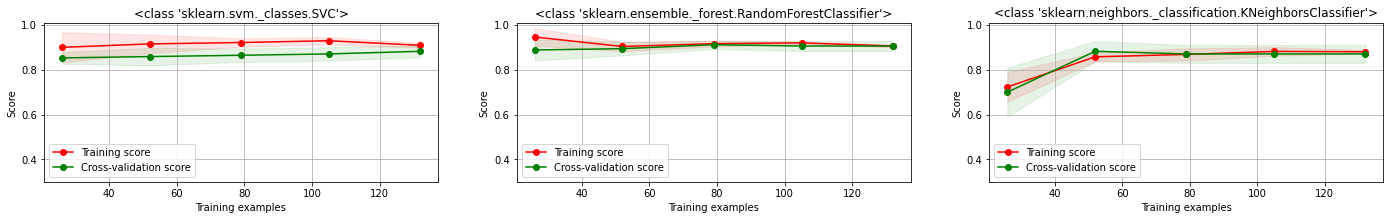

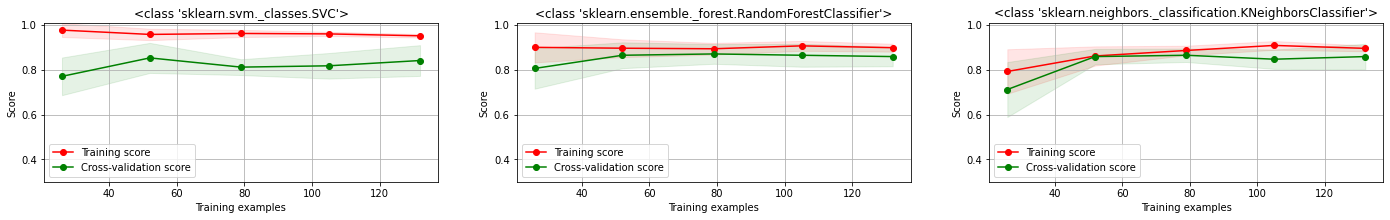

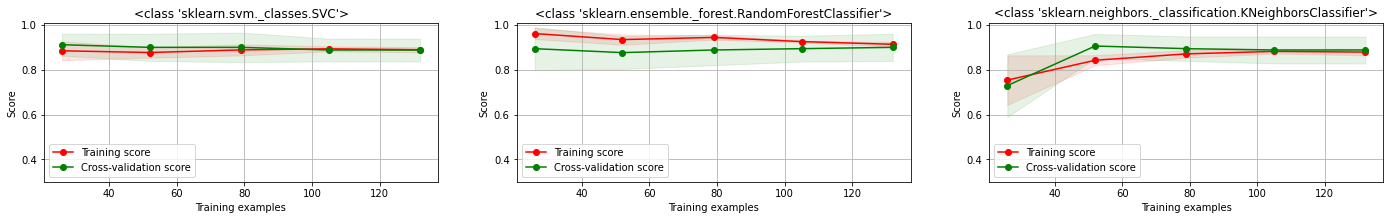

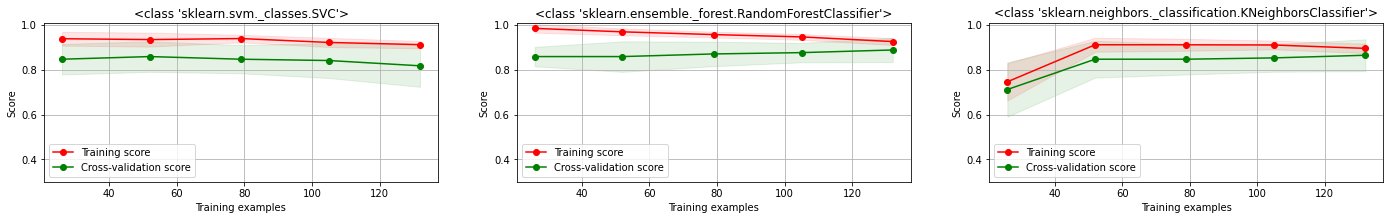

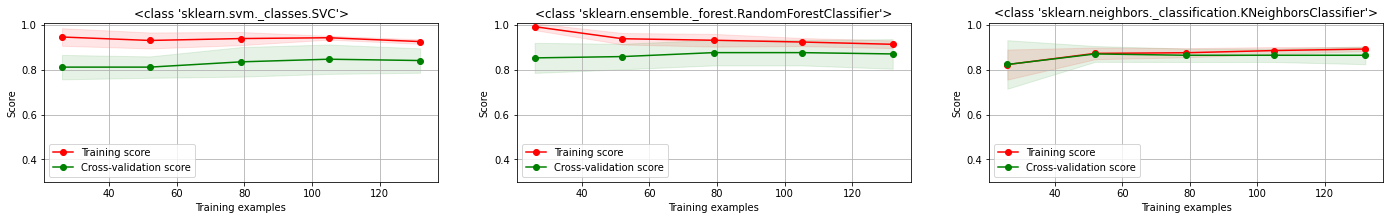

In [28]:
skf_outer = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Initialization
FEATURES_SELECTED_TOTAL = list()
fold = 0

# Create dataframes
ACCURACY = pd.DataFrame(columns=['SVM', 'RF', 'KNN'])
ACCURACY_BALANCED = pd.DataFrame(columns=['SVM', 'RF', 'KNN'])
AUC = pd.DataFrame(columns=['SVM', 'RF', 'KNN'])

for train_index, test_index in skf_outer.split(DATA_FEAT_SEL, LABELS_SEL):
    fold += 1
    print(f'\n \n Run {fold} of outer crossvalidation')

    # Split data into train and test set for outer crossvalidation
    X_train, X_test = np.array(DATA_FEAT_SEL)[train_index], np.array(DATA_FEAT_SEL)[test_index]
    y_train, y_test = np.array(LABELS_SEL)[train_index], np.array(LABELS_SEL)[test_index]

    # ---------------------------------- IMPUTATION -----------------------------------

    X_train_imp, X_test_imp = knn_impute_train_test_set(X_train, X_test)

    # ------------------------------------ SCALING ----------------------------------------
    X_train_scal, X_test_scal = scale_train_test_set(X_train_imp, X_test_imp)

    # ------------------------------------ FEATURE SELECTION -------------------------------

    # Determining optimal number of features k
    k_options = [20, 30, 40, 50]
    k_optimal = select_hyperparameter_feature_selection(X_train_scal, y_train, k_options)
    print(f'The optimal k value for fold {fold} is: {k_optimal}')

    # Univariate feature selection
    X_train_sel, X_test_sel, selected_indices = select_features_univariate(
                                                                          X_train_scal, y_train, 
                                                                          X_test_scal, k_value=k_optimal)

    print(f'\n The following column indices of features were selected by'\
          f'univariate feature selection: \n {selected_indices}')

    # Determine names of features that were selected
    features_selected = list()
    for index in selected_indices:
        features_selected.append(DATA_FEAT_SEL.columns[index])
    FEATURES_SELECTED_TOTAL.append(features_selected)

    # -------------- INNER CROSSVALIDATION FOR DETERMINATION OF HYPERPARAMETERS OF CLASSIFIERS ----------------------------
    svm_classifier = svm_randomized_search(X_train_sel, y_train)

    rf_classifier = rf_randomized_search(X_train_sel, y_train)

    knn_classifier = knn_randomized_search(X_train_sel, y_train)

    clfs = [svm_classifier, rf_classifier, knn_classifier]
    clfs_names = ['SVM', 'RF', 'KNN']

    # ---------------- TRAIN AND TEST CLASSIFIERS (OUTER CROSSVALIDATION) ------------------------------------------------
    # Initialisation
    acc_dict = dict()
    accuracy_total = list()

    bal_acc_dict = dict()
    bal_acc_total = list()

    roc_auc_score_dict = dict()
    roc_auc_score_total = list()

    # Determine performance
    for clf, name in zip(clfs, clfs_names):
        acc_dict[name], bal_acc_dict[name], roc_auc_score_dict[name] = get_performance_classifier(
                                                                                                 clf, X_train_sel, y_train,                                                                                                            X_test_sel, y_test)

    accuracy_total.append(acc_dict)
    bal_acc_total.append(bal_acc_dict)
    roc_auc_score_total.append(roc_auc_score_dict)

    ACCURACY = ACCURACY.append(acc_dict, ignore_index=True)
    ACCURACY_BALANCED = ACCURACY_BALANCED.append(bal_acc_dict, ignore_index=True)
    AUC = AUC.append(roc_auc_score_dict, ignore_index=True)

    print(f'Regular accuracy: \n {acc_dict}')
    print(f'Balanced accuracy: \n {bal_acc_dict}')
    print(f'Roc auc score: \n {roc_auc_score_dict}')

    # -------------------- LEARNING CURVES --------------------------------------------------
    # Initialisation
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    num = 0
    fig = plt.figure(figsize=(24, 8*len(clfs)))

    # Merge LGG and GBM patients
    X_total = np.concatenate((X_train_sel, X_test_sel), axis=0)
    y_total = np.concatenate([y_train, y_test])

    # Compute learning curves
    for clf in clfs:
        title = str(type(clf))
        ax = fig.add_subplot(7, 3, num+1)
        plot_learning_curve(clf, title, X_total, y_total, ax, ylim=(0.3, 1.01),
                            cv=cv, train_sizes=np.linspace(0.2, 1, 5))
        num += 1

## 7. Performance of classifiers

In [29]:
# Determine mean accuracy, balanced accuracy and AUC score per classifier
MEAN_ACC = ACCURACY.mean()
print(f'The mean accuracy per classifier is: \n{MEAN_ACC}')
MEAN_ACC_BAL = ACCURACY_BALANCED.mean()
print(f'The mean balanced accuracy per classifier is: \n{MEAN_ACC_BAL}')
MEAN_AUC = AUC.mean()
STD_AUC = AUC.std()
print(f'The mean AUC per classifier is: \n{MEAN_AUC}')
print(f'The standard deviation of AUC per classifier is: \n{STD_AUC}')

The mean accuracy per classifier is: 
SVM    0.873440
RF     0.891444
KNN    0.891622
dtype: float64
The mean balanced accuracy per classifier is: 
SVM    0.855055
RF     0.869982
KNN    0.867289
dtype: float64
The mean AUC per classifier is: 
SVM    0.935031
RF     0.931844
KNN    0.928602
dtype: float64
The standard deviation of AUC per classifier is: 
SVM    0.049579
RF     0.062710
KNN    0.055146
dtype: float64
